# Dynamic lot-size model

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Formulation

$$
\begin{align}
    \text{min}~~ & \sum_{t \in T}{(h_{t} I_{t} + s_{t} y_{t})} \\
    \text{s.t.}~~ & I_{t} = I_{t - 1} + x_{t} - d_{t} & \forall ~ t \in T; t \geq 2\\
    & I_{1} = I_{0} + x_{1} - d_{1}\\
    & x_{t} \leq M y_{t} & \forall ~ t \in T \\
    & x_{t}; I_{t} \geq 0 & \forall ~ t \in T \\
    & y_{t} \in \left \{ 0, 1 \right \} & \forall ~ t \in T\\
\end{align}
$$

## Import data

In [2]:
dataset = pd.read_csv("../data/input_wagner.csv", index_col=0)
dataset.head()

,setup_cost,inventory_cost,demand
1,85,1.0,69
2,102,1.0,29
3,102,1.0,36
4,101,1.0,61
5,98,1.0,61


In [3]:
# Obtain the maximum cost for comparison
max_cost = dataset.setup_cost.sum()
print(f"Maximum cost: {max_cost:.1f}")

Maximum cost: 1234.0


In [4]:
# Limit that makes sense to antecipy production (holding invertory larger than setup)
def get_max_antecip(t, dataset=dataset):

    total_inv = 0
    d = dataset.demand[t]
    s = dataset.setup_cost[t]
    out = t

    for i in range(1, t - dataset.index[0] + 1):
        h = dataset.inventory_cost[t - i]
        if total_inv + h * d <= s:
            total_inv = total_inv + h * d
            out = t - i
        else:
            break

    return out


def get_max_prod(t, dataset=dataset):
    df = dataset.query(f"max_antecip <= {t} & index >= {t}")
    return df.demand.sum()

In [5]:
dataset["max_antecip"] = [get_max_antecip(t, dataset=dataset) for t in dataset.index]
dataset["max_prod"] = [get_max_prod(t, dataset=dataset) for t in dataset.index]

## pyomo model

In [6]:
model = pyo.ConcreteModel()

In [7]:
model.T = pyo.Set(initialize=list(dataset.index))

In [8]:
model.d = pyo.Param(model.T, initialize=dataset.demand)
model.s = pyo.Param(model.T, initialize=dataset.setup_cost)
model.h = pyo.Param(model.T, initialize=dataset.inventory_cost)
model.M = pyo.Param(model.T, initialize=dataset.max_prod)

In [9]:
model.x = pyo.Var(model.T, within=pyo.NonNegativeReals)
model.y = pyo.Var(model.T, within=pyo.Binary)
model.I = pyo.Var(model.T, within=pyo.NonNegativeReals)

In [10]:
def inventory_rule(model, t):
    if t == model.T.first():
        return model.I[t] == model.x[t] - model.d[t]
    else:
        return model.I[t] == model.I[model.T.prev(t)] + model.x[t] - model.d[t]

model.inventory_rule = pyo.Constraint(model.T, rule=inventory_rule)

In [11]:
def active_prod(model, t):
    return model.x[t] <= model.M[t] * model.y[t]

model.active_prod = pyo.Constraint(model.T, rule=active_prod)

In [12]:
def total_holding(model):
    return sum(model.h[t] * model.I[t] for t in model.T)

def total_setup(model):
    return sum(model.s[t] * model.y[t] for t in model.T)

def total_cost(model):
    return total_setup(model) + total_holding(model)

model.obj = pyo.Objective(rule=total_cost, sense=pyo.minimize)

## Solution

In [13]:
solver = pyo.SolverFactory("cbc")

In [14]:
solver.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Users\Bruno\Documents\Programas\Cbc\bin\cbc.exe -printingOptions all -import C:\Users\Bruno\AppData\Local\Temp\tmpi190xi3z.pyomo.lp -stat=1 -solve -solu C:\Users\Bruno\AppData\Local\Temp\tmpi190xi3z.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 23 (-2) rows, 35 (-2) columns and 57 (-3) elements
Statistics for presolved model
Original problem has 12 integers (12 of which binary)
Presolved problem has 12 integers (12 of which binary)
==== 11 zero objective 11 different
11 variables have objective of 0
12 variables have objective of 1
1 variables have objective of 85
1 variables have objective of 86
2 variables have objective of 98
1 variables have objective of 101
2 variables have objective of 102
1 variables have objective of 105
1 variables have objective of 110
2 variables have objective of 114
1 variables have objective of 119
==== absolute obj

{'Problem': [{'Name': 'unknown', 'Lower bound': 864.0, 'Upper bound': 864.0, 'Number of objectives': 1, 'Number of constraints': 23, 'Number of variables': 35, 'Number of binary variables': 12, 'Number of integer variables': 12, 'Number of nonzeros': 24, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.11, 'Wallclock time': 0.11, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 7}}, 'Error rc': 0, 'Time': 0.2066173553466797}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [15]:
opt_value = model.obj()
print(f"Best cost {opt_value}")
print(f"% savings {100 * (1 - opt_value / max_cost) :.2f}")

Best cost 864.0
% savings 29.98


In [16]:
dataset["production"] = [model.x[t].value for t in dataset.index]
dataset["inventory"] = [model.I[t].value for t in dataset.index]

In [17]:
dataset[["demand", "production", "inventory"]]

,demand,production,inventory
1,69,98.0,29.0
2,29,0.0,0.0
3,36,97.0,61.0
4,61,0.0,0.0
5,61,121.0,60.0
6,26,0.0,34.0
7,34,0.0,0.0
8,67,112.0,45.0
9,45,0.0,0.0
10,67,67.0,0.0


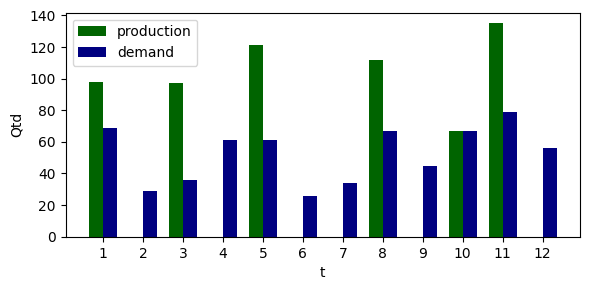

In [18]:
fig, ax = plt.subplots(figsize=[6, 3], dpi=100)
x = dataset.index
width = 0.35
ax.bar(x - width/2, dataset.production, width, color="darkgreen", label="production")
ax.bar(x + width/2, dataset.demand, width, color="navy", label="demand")
ax.set_xticks(x)
ax.set_ylabel("Qtd")
ax.set_xlabel("t")
ax.legend()
fig.tight_layout()
plt.show()